In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import optimize as opt

# Note: all these functions can be found in the 'inorg_b' module
# https://github.com/oscarbranson/Farmer_2018_Supplement/tree/master/inorg_b
from inorg_b import phreeqpy_fns as pf
from inorg_b import load
from inorg_b.helpers import d11_2_A11, A11_2_d11, err, extract_model_vars
from inorg_b.model import fitfn, predfn, fitfn_single_species_R, predfn_single_species_R
from inorg_b.plots import model_vs_data

# presentation niceties
idx = pd.IndexSlice
pd.options.mode.chained_assignment = None
plt.rcParams['figure.dpi'] = 120

# Supplement 3: Model application to all available paired (B/Ca, $\delta^{11}B$) data

### Problem: 

We find that a key control over the B content and isotopic composition of calcite is precipitation rate. Previous studies with paired B/Ca and $\delta^{11}B$ measurements (Mavromatis et al, 2015; Noireaux et al, 2016; Kaczmarek et al, 2016) show no, or only weak relationships with precipitation rate:

In [2]:
# load data
rd = load.processed()

In [3]:
cdict = {'Noireaux': 'C0',
         'Uchikawa': 'C1'}

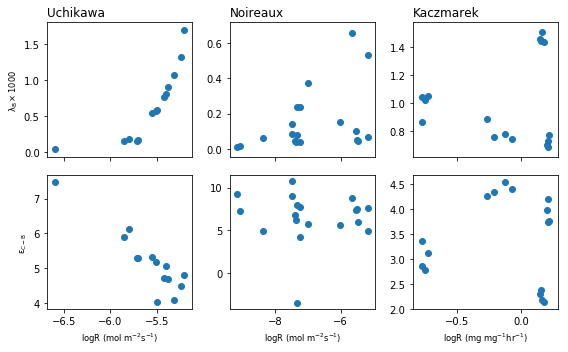

In [4]:
fig, axs = plt.subplots(2, 3, figsize=[8, 5])

phase = 'Calcite'

# plot our data
exp = 'Uchikawa'
slc = idx[:, exp, phase]
axs[0,0].scatter(rd.loc[slc, ('Solid', 'logR')], rd.loc[slc, ('Solid', 'LambdaB')])
axs[1,0].scatter(rd.loc[slc, ('Solid', 'logR')], rd.loc[slc, ('Solid', 'EpsilonB')])
axs[0,0].set_title(exp, loc='left')

# plot mavromatis/noireaux data
exp = 'Noireaux'
slc = idx[:, exp, phase]
axs[0,1].scatter(rd.loc[slc, ('Solid', 'logR')], rd.loc[slc, ('Solid', 'LambdaB')])
axs[1,1].scatter(rd.loc[slc, ('Solid', 'logR')], rd.loc[slc, ('Solid', 'EpsilonB')])
axs[0,1].set_title(exp, loc='left')

# plot kakzmarek data
exp = 'Kaczmarek'
slc = idx[:, exp, phase]
axs[0,2].scatter(rd.loc[slc, ('Solid', 'logR')], rd.loc[slc, ('Solid', 'LambdaB')])
axs[1,2].scatter(rd.loc[slc, ('Solid', 'logR')], rd.loc[slc, ('Solid', 'EpsilonB')])
axs[0,2].set_title(exp, loc='left')

units = ['$mol\ m^{-2} s^{-1}$', '$mol\ m^{-2} s^{-1}$', '$mg\ mg^{-1} hr^{-1}$']
i = 0
for ax in axs.flat:
    if ax.is_last_row():
        ax.set_xlabel('logR (' + units[i] + ')')
        i += 1
        if ax.is_first_col():
            ax.set_ylabel('$\epsilon_{C-B}$')
    if ax.is_first_row():
        ax.set_xticklabels([])
        if ax.is_first_col():
            ax.set_ylabel('$\lambda_B \\times 1000$')
fig.tight_layout()

### Is there really no pattern with R?
Estimating precipitation rates is complex, and each of these studies used a different method - is it possible that the lack of pattern could arise from problems in precipitation rate estimates?

We can get a rough idea of how good the precipitation rate estimates are by looking at the relationship between saturation index ($SI = \Omega - 1$) and precipitation rate.
This is a well-established relationship in inorganic precipitates (e.g. Zhang and Nancollas, 1998), where precipitation rates scales with $SI$ following the form:

$$ R = A\ SI^B $$

As none of these studies include significant crystal growth inhibitors in their growth solutions (e.g. Mg or organic molecules), it's reasonable to expect that their estimated precipitations rates should be related to $SI$ following this form.

## $SI$ vs. Precip Rate

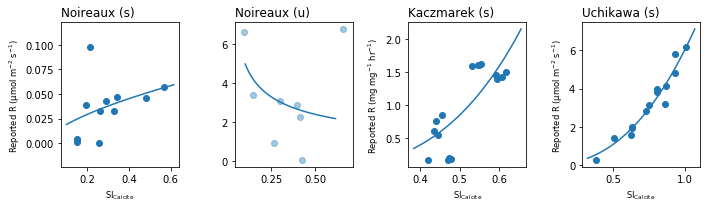

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))

phase = 'Calcite'

def Rfn(SI, k, n):
    """R as a function of SI"""
    return k * SI**n

rd.dropna(inplace=True, subset=[('Solid', 'logR')])

mu = {'Noireaux': (1e6, '$\mu mol\ m^{-2}\ s^{-1}$'),
      'Kaczmarek': (1, '$mg\ mg^{-1}\ hr^{-1}$'),
      'Uchikawa': (1e6, '$\mu mol\ m^{-2}\ s^{-1}$')}

for exp, ax in zip(['Noireaux', 'Kaczmarek', 'Uchikawa'], axs[[0,2,3]]):
    slc = idx[:, exp, phase]
    ind = rd.loc[slc, ('Solid', 'seeds')]
    
    m, u = mu[exp]

    x = rd.loc[slc, ('pitzer', 'SIc')].astype(float).values
    y = 10**rd.loc[slc, ('Solid', 'logR')].astype(float).values * m
    
    ax.scatter(x[ind], y[ind], c='C0', label='Seeded')
    
    if any(~ind):
        axs[1].scatter(x[~ind], y[~ind], c='C0', alpha=0.4, label='Unseeded')
        p, cov = curve_fit(Rfn, x[~ind], y[~ind])
        SIn = np.linspace(*ax.get_xlim())
        axs[1].plot(SIn, Rfn(SIn, *p))
        axs[1].set_title(exp + ' (u)', loc='left')
        
#     ax.set_ylim(rangecalc(y))
    ax.set_xlabel('$SI_{Calcite}$')
    ax.set_ylabel('Reported R (' + u + ')')
    ax.set_title(exp + ' (s)', loc='left')
    
    # fit line
    p, cov = curve_fit(Rfn, x[ind], y[ind])
    SIn = np.linspace(*ax.get_xlim())
    ax.plot(SIn, Rfn(SIn, *p))
    
# axs[0].legend()
# axs[0].set_ylim(-0.3, 7.2)
    
fig.tight_layout()

fig.savefig('../../Figures/S4_SI_vs_R.pdf')

It is clear from this that only the precipitation rate data of Uchikawa et al. (2015) closely adhere to SI. Absent any other confounding factor that might have influenced precipitation rate in these other studies, this highlights potential issues with the methods used to estimate precipitation rate by Noireaux et al (2015) and Kaczmarek et al (2016).

It may therefore be informative to consider the chemistry of their precipitates as a function of $SI$, rather than their reported precipitation rates.

## $SI$ Plot

/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


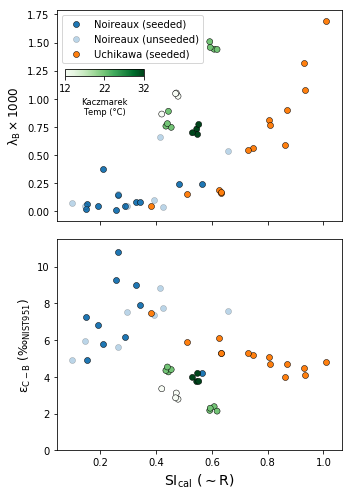

In [6]:
fig, axs = plt.subplots(2, 1, figsize=[5,7], sharex=True)

phase = 'Calcite'

cax, iax = axs

for exp in ['Noireaux', 'Uchikawa']:
    
    slc = idx[:, exp, phase]
    ind = rd.loc[slc, ('Solid', 'seeds')]
    cax.scatter(rd.loc[slc, ('pitzer', 'SIc')][ind],
                rd.loc[slc, ('Solid', 'LambdaB')][ind], label=exp + ' (seeded)',
                lw=0.5, edgecolor='k', c=cdict[exp])
    
    iax.scatter(rd.loc[slc, ('pitzer', 'SIc')][ind],
                rd.loc[slc, ('Solid', 'EpsilonB')][ind], label=exp + ' (seeded)',
                lw=0.5, edgecolor='k', c=cdict[exp])
    
    if any(~ind):
        cax.scatter(rd.loc[slc, ('pitzer', 'SIc')][~ind],
                rd.loc[slc, ('Solid', 'LambdaB')][~ind], label=exp + ' (unseeded)',
                lw=0.5, edgecolor='k', alpha=0.3, c=cdict[exp])
    
        iax.scatter(rd.loc[slc, ('pitzer', 'SIc')][~ind],
                    rd.loc[slc, ('Solid', 'EpsilonB')][~ind], label=exp + ' (unseeded)',
                    lw=0.5, edgecolor='k', alpha=0.3, c=cdict[exp])


exp = 'Kaczmarek'
slc = idx[:, exp, phase]
cm = cax.scatter(rd.loc[slc, ('pitzer', 'SIc')].values,
                 rd.loc[slc, ('Solid', 'LambdaB')].values,
                 c=rd.loc[slc, ('Solution', 'Temp (°C)')], cmap=plt.cm.Greens,
                 lw=0.5, edgecolor='k')

iax.scatter(rd.loc[slc, ('pitzer', 'SIc')],
            rd.loc[slc, ('Solid', 'EpsilonB')],
            c=rd.loc[slc, ('Solution', 'Temp (°C)')], cmap=plt.cm.Greens,
            lw=0.5, edgecolor='k')

cmx = fig.add_axes([.19,.84,.22,.015])
cb = plt.colorbar(cm, cax=cmx, label='Kaczmarek\nTemp (°C)', orientation='horizontal')
cb.set_ticks(rd.loc[slc, ('Solution', 'Temp (°C)')].unique())

cax.legend()
cax.set_ylabel('$\lambda_B \\times 1000$', fontsize=12)
iax.set_ylabel('$\epsilon_{C-B}\ (\u2030_{NIST951})$', fontsize=12)

iax.set_ylim(0,11.5)

iax.set_xlabel('$SI_{cal}\ (\sim R)$', fontsize=14)
fig.tight_layout()

fig.savefig('../../Figures/Fig6-SI-plot.pdf')

Plotted as a function of $SI$, some much more coherent patterns begin to appear in the data. In particular:

1. All $\lambda_B$ data shows a positive relationship with $SI$.
2. The $\lambda_B$ of Noireaux's data now (mostly) forms a continuum with our data.
3. Noireaux's $\epsilon_{C-B}$ data may also be consistent with a continuation of our data, although with significant scatter.
4. Kaczmarek's data are offset in absolute values in both $\lambda_B$ and $\epsilon_{C-B}$, but show trends consistent with our data.

Based on all this, it seems likely that $SI$ is doing a better job of capturing precipitation rate than the rate estimates provided by the studies.

From here, we'll make a leap, and use the best defined relationship between $SI$ and $R$ (from our data) to calculate precipitation rate for all the other studies.

This is flawed, as solution chemistry and precipitation conditions very between studies, but is a good approximation to allow us to apply our model to all existing data.

### Apply our $SI$-$R$ relationship to all data:

In [7]:
# Relationship between SI and R in Uchikawa data.
slc = idx[:, 'Uchikawa', phase]
x = rd.loc[slc, ('pitzer', 'SIc')].astype(float).values
y = 10**rd.loc[slc, ('Solid', 'logR')].astype(float).values

p, cov = curve_fit(Rfn, x, y)
# ax.plot(SIn, Rfn(SIn, *p))

# apply to all data
rd.loc[:, ('Solid', 'calc_R')] = Rfn(rd.loc[:, ('pitzer', 'SIc')].values, *p).astype(float)

We can now plot all data as a function of a uniform, $SI$-derived precipitation rate.

## Precip Rate plot

/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


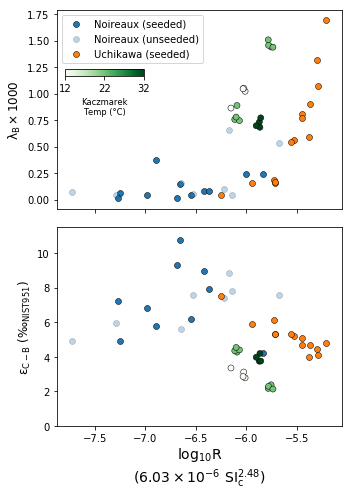

In [8]:
fig, axs = plt.subplots(2, 1, figsize=[5,7], sharex=True)

phase = 'Calcite'

cax, iax = axs

for exp in ['Noireaux', 'Uchikawa']:
    
    slc = idx[:, exp, phase]
    ind = rd.loc[slc, ('Solid', 'seeds')]
    
#     xo = rd.loc[slc, ('pitzer', 'SIc')]
#     x = np.log10(Rfn(xo, *p).astype(float))
    x = np.log10(rd.loc[slc, ('Solid', 'calc_R')].values)
    
    cax.scatter(x[ind],
                rd.loc[slc, ('Solid', 'LambdaB')][ind], label=exp + ' (seeded)',
                lw=0.5, edgecolor='k', c=cdict[exp])
    
    iax.scatter(x[ind],
                rd.loc[slc, ('Solid', 'EpsilonB')][ind], label=exp + ' (seeded)',
                lw=0.5, edgecolor='k', c=cdict[exp])
    
    if any(~ind):
        cax.scatter(x[~ind],
                rd.loc[slc, ('Solid', 'LambdaB')][~ind], label=exp + ' (unseeded)',
                lw=0.5, edgecolor='k', alpha=0.3, c=cdict[exp])
    
        iax.scatter(x[~ind],
                    rd.loc[slc, ('Solid', 'EpsilonB')][~ind], label=exp + ' (unseeded)',
                    lw=0.5, edgecolor='k', alpha=0.3, c=cdict[exp])
        
exp = 'Kaczmarek'
slc = idx[:, exp, phase]
xo = rd.loc[slc, ('pitzer', 'SIc')]
x = np.log10(Rfn(xo, *p).astype(float))
cm = cax.scatter(x.values,
                 rd.loc[slc, ('Solid', 'LambdaB')].values,
                 c=rd.loc[slc, ('Solution', 'Temp (°C)')], cmap=plt.cm.Greens,
                 lw=0.5, edgecolor='k')

iax.scatter(x,
            rd.loc[slc, ('Solid', 'EpsilonB')],
            c=rd.loc[slc, ('Solution', 'Temp (°C)')], cmap=plt.cm.Greens,
            lw=0.5, edgecolor='k')

cmx = fig.add_axes([.19,.84,.22,.015])
cb = plt.colorbar(cm, cax=cmx, label='Kaczmarek\nTemp (°C)', orientation='horizontal')
cb.set_ticks(rd.loc[slc, ('Solution', 'Temp (°C)')].unique())

cax.legend()
cax.set_ylabel('$\lambda_B \\times 1000$', fontsize=12)
iax.set_ylabel('$\epsilon_{C-B}\ (\u2030_{NIST951})$', fontsize=12)
# iax.axhline(0, ls='dashed', zorder=-1, c=(0,0,0,0.3))

iax.set_ylim(0,11.5)

iax.set_xlabel('$log_{10}R$\n$(6.03 \\times 10^{-6}\ SI_c^{2.48})$', fontsize=14)
fig.tight_layout()

With the data in this form, we can apply our SKM to all data:

# Data Fitting

In fitting the data, we exclude 'unseeded' precipitates, where the link between $SI$ and $R$ may be less straightforward, and Kaczmarek's high-temperature points, where there appears to be a change in B incorporation that is not parameterised in the model. It is possible that this shift could be accommodated by including a temperature sensitivity in our partitioning parameters, but there are insufficient constraints in the data to justify this, so we have excluded them.

Additionally, we have excluded Noireau's data point that falls below the $\delta^{11}B_{BO4}$ line, which they identify as an anomalous point.

Excluding data is unsatisfactory, but justified in this case because in both cases there are likely confounding influences that are not parameterised in the model, so would not be expected to fit.

In [9]:
# isolate seeded data only, remove Kaczmarek high-temperature point
rds = rd.loc[rd.loc[:, ('Solid', 'seeds')] &
             (rd.loc[:, ('Solution', 'Temp (°C)')] < 27) & 
             (rd.loc[:, ('Solid', 'EpsilonB')] > 0)]
# create empty dict to store best-fit parameters
fits = {}
# use best fits from our data as initial parameter guesses.
initial_guess = np.load('fit_params.npy')
# calculated logR from calculated R, for plotting
rds.loc[:, ('Solid', 'log_calc_R')] = np.log10(rds.loc[:, ('Solid', 'calc_R')]).values

## Fit Noireaux Data

In [10]:
exp = 'Noireaux'

In [11]:
# prepare fitting variables
cind = idx[:, exp, :]

# Precipitation Rate
Rp = (rds.loc[cind, ('Solid', 'calc_R')]).values
logRp = np.log10(Rp)
# Solution BO3/C and BO4/CO3 ratios
rL3 = (rds.loc[cind, ('pitzer', 'BOH3')] / rds.loc[cind, ('pitzer', 'C')]).astype(float).values
rL4 = (rds.loc[cind, ('pitzer', 'BOH4_free')] / rds.loc[cind, ('pitzer', 'CO3')]).astype(float).values
# B/DIC for LambdaB calculation
B_DIC = (rds.loc[cind, ('pitzer', 'B')] / rds.loc[cind, ('pitzer', 'C')]).astype(float).values
# Isotopic content of each B species
ABO3 = d11_2_A11(rds.loc[cind, ('Solution', 'd11BO3 (permil vs NIST951)')].astype(float).values)
ABO4 = d11_2_A11(rds.loc[cind, ('Solution', 'd11BO4 (permil vs NIST951)')].astype(float).values)
# Borate d11B for EpsilonB calculation
dBO4 = rds.loc[cind, ('Solution', 'd11BO4 (permil vs NIST951)')].astype(float).values

# Measured LambdaB and EpsilonB fo residual calculation
LambdaB = rds.loc[cind, ('Solid', 'LambdaB')].astype(float).values
EpsilonB = rds.loc[cind, ('Solid', 'EpsilonB')].astype(float).values

# bias factor applied to lambda residuals to account for difference in
# the variance of the two parameters
lambda_bias = np.ptp(EpsilonB) / np.ptp(LambdaB)

In [12]:
fit = opt.minimize(fitfn, x0=initial_guess,
                   method='Powell', options={'maxiter': 2000, 'disp': True},
                   args=(Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4,
                         LambdaB, EpsilonB, 1, 1, lambda_bias))

fits[exp] = fit

Optimization terminated successfully.
         Current function value: 19.379878
         Iterations: 10
         Function evaluations: 595


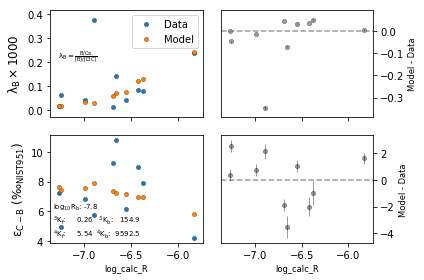

In [13]:
_ = model_vs_data(fit.x, rds, exp=exp, xvar=('Solid', 'log_calc_R'), Rvar=('Solid', 'calc_R'))

In [14]:
initial_guess = (2000, 200, 1.01, 1, -6.22)

fit = opt.minimize(fitfn_single_species_R, x0=initial_guess,
                   method='Powell', options={'maxiter': 2000, 'disp': True},
                   args=(Rp, rL4, B_DIC, dBO4,
                         LambdaB, EpsilonB, 1, 1, lambda_bias))

pred = predfn_single_species_R(*fit.x, Rp, rL4, B_DIC, dBO4)

Optimization terminated successfully.
         Current function value: 18.146679
         Iterations: 20
         Function evaluations: 1210


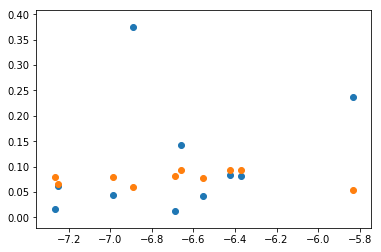

In [15]:
plt.scatter(logRp, LambdaB)
plt.scatter(logRp, pred[0])

The fit here is not perfect, although it's hard to determine whether the relatively poor fit is due to a systematic failing of the model, or the considerable scatter in the data.

## Fit Kaczmarek Data

In [16]:
exp = 'Kaczmarek'

In [17]:
# prepare fitting variables
cind = idx[:, exp, :]

# Precipitation Rate
Rp = (rds.loc[cind, ('Solid', 'calc_R')]).values
logRp = np.log10(Rp)
# Solution BO3/C and BO4/CO3 ratios
rL3 = (rds.loc[cind, ('pitzer', 'BOH3')] / rds.loc[cind, ('pitzer', 'C')]).astype(float).values
rL4 = (rds.loc[cind, ('pitzer', 'BOH4_free')] / rds.loc[cind, ('pitzer', 'CO3')]).astype(float).values
# B/DIC for LambdaB calculation
B_DIC = (rds.loc[cind, ('pitzer', 'B')] / rds.loc[cind, ('pitzer', 'C')]).astype(float).values
# Isotopic content of each B species
ABO3 = d11_2_A11(rds.loc[cind, ('Solution', 'd11BO3 (permil vs NIST951)')].astype(float).values)
ABO4 = d11_2_A11(rds.loc[cind, ('Solution', 'd11BO4 (permil vs NIST951)')].astype(float).values)
# Borate d11B for EpsilonB calculation
dBO4 = rds.loc[cind, ('Solution', 'd11BO4 (permil vs NIST951)')].astype(float).values

# Measured LambdaB and EpsilonB fo residual calculation
LambdaB = rds.loc[cind, ('Solid', 'LambdaB')].astype(float).values
EpsilonB = rds.loc[cind, ('Solid', 'EpsilonB')].astype(float).values

# bias factor applied to lambda residuals to account for difference in
# the variance of the two parameters
lambda_bias = np.ptp(EpsilonB) / np.ptp(LambdaB)

In [18]:
fit = opt.minimize(fitfn, x0=initial_guess,
                   method='Powell', options={'maxiter': 2000, 'disp': True},
                   args=(Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4,
                         LambdaB, EpsilonB, 1, 1, lambda_bias))

fits[exp] = fit

Optimization terminated successfully.
         Current function value: 2.131443
         Iterations: 18
         Function evaluations: 1276


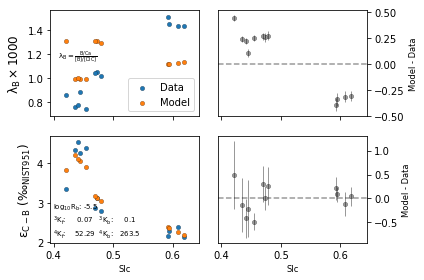

In [19]:
_ = model_vs_data(fit.x, rds, exp=exp, xvar=('pitzer', 'SIc'), Rvar=('Solid', 'calc_R'))

In [20]:
fit = opt.minimize(fitfn_single_species_R, x0=(2000, 200, 1.01, 1, -6.22),
                   method='Powell', options={'maxiter': 2000, 'disp': True},
                   args=(Rp, rL4, B_DIC, dBO4,
                         LambdaB, EpsilonB, 1, 1, lambda_bias))

pred = predfn_single_species_R(*fit.x, Rp, rL4, B_DIC, dBO4)

Optimization terminated successfully.
         Current function value: 1.529899
         Iterations: 27
         Function evaluations: 1535


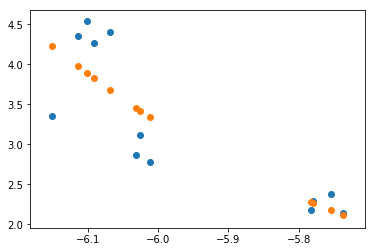

In [21]:
plt.scatter(logRp, EpsilonB)
plt.scatter(logRp, pred[1])

The fit to Kaczmarek's data is excellent (within the limitations of the data), in particular in $\lambda_B$, where there is no discrepancy at high $R$.

## Import Uchikawa Fit Parameters

In [22]:
fits['Uchikawa'] = {'x': np.load('fit_params.npy')}

## Plot Results

/home/oscar/miniconda3/envs/py3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


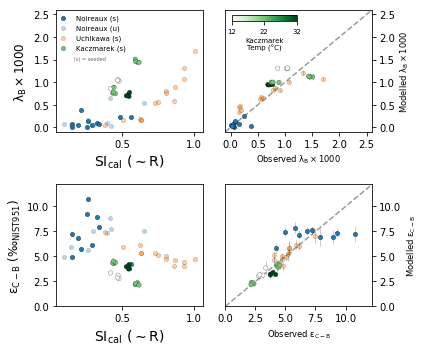

In [23]:
fig, axs = plt.subplots(2, 2, figsize=[6, 5])

phase = 'Calcite'

uni_opts = {'lw': 0.3,
            'edgecolor': (0,0,0,0.7),
            's': 20}
adict = {'Noireaux': 1,
         'Uchikawa': 0.4}

(cax, rcax), (iax, riax) = axs

for exp in ['Noireaux', 'Uchikawa']:
    slc = idx[:, exp, phase]
    ind = rd.loc[slc, ('Solid', 'seeds')]
    x = rd.loc[slc, ('pitzer', 'SIc')]
    cax.scatter(x[ind],
                rd.loc[slc, ('Solid', 'LambdaB')][ind], label=exp + ' (s)',
                c=cdict[exp], alpha=adict[exp], **uni_opts)
    
    iax.scatter(x[ind],
                rd.loc[slc, ('Solid', 'EpsilonB')][ind], label=exp + ' (s)',
                c=cdict[exp], alpha=adict[exp], **uni_opts)
    
    if any(~ind):
        cax.scatter(x[~ind],
                    rd.loc[slc, ('Solid', 'LambdaB')][~ind], label=exp + ' (u)',
                    alpha=0.3, c=cdict[exp], **uni_opts)
    
        iax.scatter(x[~ind],
                    rd.loc[slc, ('Solid', 'EpsilonB')][~ind], label=exp + ' (u)',
                    alpha=0.3, c=cdict[exp], **uni_opts)
        
exp = 'Kaczmarek'
slc = idx[:, exp, phase]
cm = cax.scatter(rd.loc[slc, ('pitzer', 'SIc')].values,
                 rd.loc[slc, ('Solid', 'LambdaB')].values,
                 c=rd.loc[slc, ('Solution', 'Temp (°C)')], cmap=plt.cm.Greens,
                 **uni_opts)

# for legend
cax.scatter(None, None, c=plt.cm.Greens(0.5), label=exp + ' (s)', **uni_opts)

iax.scatter(rd.loc[slc, ('pitzer', 'SIc')],
            rd.loc[slc, ('Solid', 'EpsilonB')],
            c=rd.loc[slc, ('Solution', 'Temp (°C)')], cmap=plt.cm.Greens,
            **uni_opts)

# draw residuals
exp = 'Uchikawa'
slc = idx[:, exp, phase]
(logRp, Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4, LambdaB, EpsilonB, 
 LambdaB_err, EpsilonB_err, LambdaB_err_norm, EpsilonB_err_norm) = extract_model_vars(rds, exp, phase=phase)

LambdaB_pred, EpsilonB_pred = predfn(*fits[exp]['x'], Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4)

rx = rds.loc[slc, ('pitzer', 'SIc')]
rcax.scatter(LambdaB, LambdaB_pred, c=cdict[exp], alpha=adict[exp], **uni_opts)
rcax.errorbar(LambdaB,
              LambdaB_pred, 
              yerr=LambdaB_err,
              color=(0,0,0,0.2), lw=0, elinewidth=1, label='_', zorder=-1)


riax.scatter(EpsilonB, EpsilonB_pred, c=cdict[exp], alpha=adict[exp], **uni_opts)
riax.errorbar(EpsilonB,
              EpsilonB_pred, 
              yerr=EpsilonB_err,
              color=(0,0,0,0.2), lw=0, elinewidth=1, label='_', zorder=-1)

exp = 'Noireaux'
slc = idx[:, exp, phase]
(logRp, Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4, LambdaB, EpsilonB, 
 LambdaB_err, EpsilonB_err, LambdaB_err_norm, EpsilonB_err_norm) = extract_model_vars(rds, exp, ('Solid', 'calc_R'), phase)

LambdaB_pred, EpsilonB_pred = predfn(*fits[exp]['x'], Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4)

rcax.scatter(LambdaB, LambdaB_pred, c=cdict[exp], alpha=adict[exp], **uni_opts)
rcax.errorbar(LambdaB,
              LambdaB_pred, 
              yerr=LambdaB_err,
              color=(0,0,0,0.2), lw=0, elinewidth=1, label='_', zorder=-1)


riax.scatter(EpsilonB, EpsilonB_pred, c=cdict[exp], alpha=adict[exp], **uni_opts)
riax.errorbar(EpsilonB,
              EpsilonB_pred, 
              yerr=EpsilonB_err,
              color=(0,0,0,0.2), lw=0, elinewidth=1, label='_', zorder=-1)

exp = 'Kaczmarek'
slc = idx[:, exp, phase]
(logRp, Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4, LambdaB, EpsilonB, 
 LambdaB_err, EpsilonB_err, LambdaB_err_norm, EpsilonB_err_norm) = extract_model_vars(rd, exp, ('Solid', 'calc_R'))

LambdaB_pred, EpsilonB_pred = predfn(*fits[exp]['x'], Rp, rL3, rL4, B_DIC, ABO3, ABO4, dBO4)

rx = rd.loc[slc, ('pitzer', 'SIc')]
c = rd.loc[slc, ('Solution', 'Temp (°C)')]
rcax.scatter(LambdaB, LambdaB_pred, c=c, cmap=plt.cm.Greens, **uni_opts)
rcax.errorbar(LambdaB,
              LambdaB_pred, 
              yerr=LambdaB_err,
              color=(0,0,0,0.2), lw=0, elinewidth=1, label='_', zorder=-1)


riax.scatter(EpsilonB, EpsilonB_pred, c=c, cmap=plt.cm.Greens, **uni_opts)
riax.errorbar(EpsilonB,
              EpsilonB_pred, 
              yerr=EpsilonB_err,
              color=(0,0,0,0.2), lw=0, elinewidth=1, label='_', zorder=-1)



# labels and legends

cax.legend(loc=(-0.02, .64), fontsize=7, framealpha=0)
cax.set_ylim(-0.1, 2.6)
iax.set_ylim(0, 12.2)
cax.text(0.12, 0.62, '(s) = seeded', va='top', ha='left', transform=cax.transAxes, color=(0,0,0,0.6), fontsize=5)

cmx = fig.add_axes([.545, .93, .15, .015])
cb = plt.colorbar(cm, cax=cmx, orientation='horizontal')
cb.set_label('Kaczmarek\nTemp (°C)', fontsize=7)
cb.set_ticks(rd.loc[slc, ('Solution', 'Temp (°C)')].unique())
cb.ax.tick_params(labelsize=7)

rcax.set_xlim(cax.get_ylim())
rcax.set_ylim(cax.get_ylim())
rcax.set_xticks([0, .5, 1, 1.5, 2, 2.5])

riax.set_xlim(iax.get_ylim())
riax.set_ylim(iax.get_ylim())
riax.set_xticks([0, 2.5, 5, 7.5, 10])

for rx in [rcax, riax]:
#     lims = np.concatenate([rx.get_xlim(), rx.get_ylim()])
#     rxlim = [lims.min() - 0.05 * lims.ptp(), lims.max() + 0.1 * lims.ptp()]
#     rx.set_xlim(rxlim)
#     rx.set_ylim(rxlim)
    lims = rx.get_xlim()
    rx.plot(lims, lims, color=(0,0,0,0.4), ls='dashed', zorder=-1)
    rx.yaxis.tick_right()
    rx.yaxis.set_label_position('right')


# cax.legend()
cax.set_ylabel('$\lambda_B \\times 1000$', fontsize=12)
iax.set_ylabel('$\epsilon_{C-B}\ (\u2030_{NIST951})$', fontsize=12)

iax.set_xlabel('$SI_{cal}\ (\sim R)$', fontsize=14)
cax.set_xlabel('$SI_{cal}\ (\sim R)$', fontsize=14)

rcax.set_xlabel('Observed $\lambda_B \\times 1000$')
rcax.set_ylabel('Modelled $\lambda_B \\times 1000$')

riax.set_xlabel('Observed $\epsilon_{C-B}$')
riax.set_ylabel('Modelled $\epsilon_{C-B}$')

fig.tight_layout()

fig.savefig('../../Figures/Fig6-SI-plot.pdf')

In general, the model does a good job of predicting both B partitioning and isotope fractionation in all published data. It does least well on Noireaux's $\epsilon_{C-B}$ values (as evident in the non-1:1 relationship in the right panel), but given the numerous assumptions behind the extrapolation of $SI$ to $R$ that underpin this fit, the similarity between observed and predicted data is remarkable!

### Sumary of fit parameters

In [24]:
par = ['Kb3', 'Kf3', 'Kb4', 'Kf4', 'logRb']
params = pd.DataFrame(columns=par, index=['Uchikawa', 'Noireaux', 'Kaczmarek'])

for k, v in fits.items():
    params.loc[k, par] = v['x']

In [25]:
params

,Kb3,Kf3,Kb4,Kf4,logRb
Uchikawa,313.013,0.49093,7261.31,5.42315,-7.76104
Noireaux,154.883,0.255755,9592.48,5.54179,-7.78058
Kaczmarek,0.0605665,0.0686864,263.495,52.295,-5.48993


There is significant variability in the best fit parameters of the model between the different experiments. This is not surprising, as the experiments were conducted at different ionic strengths, solution chemistries, temperatures, and by different precipitation methods. All of these experimental conditions have the potential to influence the kinetic environment of the crystal growth surface, and therefore the forward and backward partition coefficients for each species.

Importantly, the *relative magnitude* of the coefficients is constant across all experiments, indicating that the mechanism implied by these parameters is the same.

Note that the best-fit values for our data here are subtly different to those presentied in Supplement 2, because we are using $R$ values estiamted from $SI$ to allow comparison between the studies, rather than the measured $R$ values.